### TASK: Build a CBOW Network (Continious Bag Of words)

- **CBOW** aims to predict a target word given its surrounding context words. 
- It treats the context words as a "bag of words," meaning the order of these words doesn't matter.

#### Architecture:
Input: One-hot encoding/ embedding vector
Hidden layer: Embeddings or Average of input words|
Output: Propability distribution over the vocabulary



In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


from tensorflow.keras.layers import Dense,Input,Embedding, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer

import gensim.downloader as api 
dataset = api.load('text8')


In [2]:
# Convert dataset to Dataframe
texts =[' '.join(line) for line in dataset]

df = pd.DataFrame(texts, columns=['text'])

# merge words
def join_words(line):
    line = ''.join(line)
    return line.split()

df['text'] = df['text'].apply(join_words)
len(df['text'])


1701

In [3]:
doc_lengths = []
for x in dataset:
    l = len(x)
    doc_lengths.append(l)

import numpy as np
np.mean(doc_lengths), np.std(doc_lengths)

(9997.182245737802, 116.17898450079628)

In [4]:
# do i just get the middle word? or do i train for the whole?
# guess we'll see
vocab_size = 20_000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])


df_train,df_test = train_test_split(df, test_size=0.3, random_state=42)

In [5]:
len(sequences)
tokenizer.word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'one': 4,
 'in': 5,
 'a': 6,
 'to': 7,
 'zero': 8,
 'nine': 9,
 'two': 10,
 'is': 11,
 'as': 12,
 'eight': 13,
 'for': 14,
 's': 15,
 'five': 16,
 'three': 17,
 'was': 18,
 'by': 19,
 'that': 20,
 'four': 21,
 'six': 22,
 'seven': 23,
 'with': 24,
 'on': 25,
 'are': 26,
 'it': 27,
 'from': 28,
 'or': 29,
 'his': 30,
 'an': 31,
 'be': 32,
 'this': 33,
 'which': 34,
 'at': 35,
 'he': 36,
 'also': 37,
 'not': 38,
 'have': 39,
 'were': 40,
 'has': 41,
 'but': 42,
 'other': 43,
 'their': 44,
 'its': 45,
 'first': 46,
 'they': 47,
 'some': 48,
 'had': 49,
 'all': 50,
 'more': 51,
 'most': 52,
 'can': 53,
 'been': 54,
 'such': 55,
 'many': 56,
 'who': 57,
 'new': 58,
 'used': 59,
 'there': 60,
 'after': 61,
 'when': 62,
 'into': 63,
 'american': 64,
 'time': 65,
 'these': 66,
 'only': 67,
 'see': 68,
 'may': 69,
 'than': 70,
 'world': 71,
 'i': 72,
 'b': 73,
 'would': 74,
 'd': 75,
 'no': 76,
 'however': 77,
 'between': 78,
 'about': 79,
 'over': 80,
 'years':

In [6]:
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)


context_size = 10
embedding_dim = 50

# input dimensions
i = Input(shape=(context_size,))
x = Embedding(vocab_size,embedding_dim)(i) # N x T x D
# take mean of each embedding vector N x T x D -> N x D
x = Lambda(lambda t: tf.reduce_mean(t,axis=1))(x) 

# output is vocab size since we need one output for each word
x = Dense(vocab_size,use_bias=False)(x)

model = Model(i,x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 10, 50)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20000)          │     1,000,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
half_context = int(context_size/2)

def data_generator(sequences,batch_size=128):
    X_batch = np.zeros((batch_size,context_size))
    Y_batch = np.zeros(batch_size)
    n_batches = int(np.ceil(len(sequences)/batch_size))
    
    while True:
        random.shuffle(sequences)
        
        #one epoch will be one pass through data
        for i in range(n_batches):
            batch_sequences = sequences[i*batch_size:(i+1)*batch_size]
            
            current_batch_size = len(batch_sequences)
            for ii in range(current_batch_size):
                seq = batch_sequences[ii]
                j = np.random.randint(0,len(seq)-context_size-1)
                x1 = seq[j:j+half_context]
                x2 = seq[j+half_context+1:j+context_size+1]
                
                X_batch[ii, :half_context] = x1
                X_batch[ii, half_context:] = x2 
                y = seq[j+ half_context]
                Y_batch[ii]=y
                
                
                yield X_batch[:current_batch_size],Y_batch[:current_batch_size]
                
                

In [8]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [10]:
#takes some time
batch_size =128
r = model.fit(
    data_generator(sequences,batch_size),
    epochs = 1000,
    steps_per_epoch=int(np.ceil(len(sequences)/batch_size))
)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7536 - loss: 9.8115
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9258 - loss: 8.9010
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8261 - loss: 6.8663
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6869 - loss: 4.4671
Epoch 5/1000
 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5723 - loss: 4.5236

KeyboardInterrupt: 

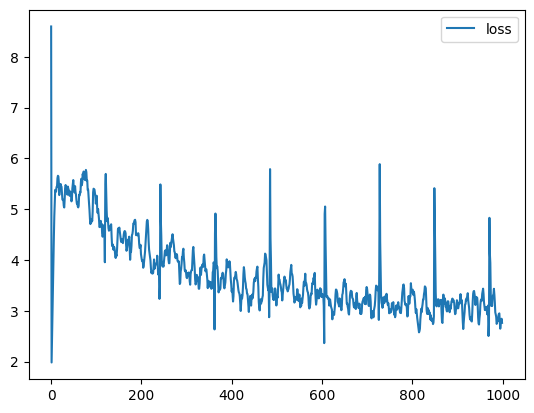

In [30]:
# Loss per iteration
plt.plot(r.history['loss'],label='loss')
plt.legend()

In [31]:
# Get embedding matrix 
embeddings = model.layers[1].get_weights()[0]
embeddings

array([[ 9.6231550e-01, -8.1565887e-01, -4.2566162e-01, ...,
         7.9189819e-01,  3.8418598e+00, -5.8663410e-01],
       [ 9.6380866e-01,  2.3647523e+00, -8.0794281e-01, ...,
        -4.0786538e+00,  5.6115335e-01,  2.3909597e+00],
       [-1.9286197e+00, -1.2756077e+00, -2.0515335e+00, ...,
        -2.7772679e+00,  2.7583497e+00,  1.1188322e-01],
       ...,
       [-3.9242944e-01, -3.5776016e-01,  3.9207312e-01, ...,
        -1.5795918e-01,  3.5818103e-01, -3.2239658e-01],
       [ 4.3478644e-01, -3.6507633e-01, -5.1736844e-01, ...,
        -4.2494261e-01, -1.0708992e+00, -1.1538512e+00],
       [-2.1475554e-04,  1.1556685e-02, -3.8979065e-02, ...,
         2.0402122e-02, -3.9909530e-02, -9.4240904e-04]], dtype=float32)

In [32]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5,algorithm='ball_tree')
neighbors.fit(embeddings)

NearestNeighbors(algorithm='ball_tree')

In [42]:
queen_idx = tokenizer.word_index['man']
queen = embeddings[queen_idx:queen_idx+1]
distances,indices = neighbors.kneighbors(queen)

for idx in indices[0]:
    word = tokenizer.index_word[idx]
    print(word)

man
mice
ease
tubes
recorded


In [44]:

def print_neighbors(query):
    queen_idx = tokenizer.word_index[query]
    queen = embeddings[queen_idx:queen_idx+1]
    _,indices = neighbors.kneighbors(queen)

    for idx in indices[0]:
        word = tokenizer.index_word[idx]
        print(word)

print_neighbors('paris')

paris
impressionist
teenage
rationalism
amd
